In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

In [5]:
data_dir = Path('/Volumes/REA/Data/fast_folders/')


In [6]:
if Path('timescales.h5').exists():
    ts = pd.read_hdf('timescales.h5', key='timescales')
else:
    all_ts = []
    for prot, name in zip(funcs.PROTEIN_DIRS, funcs.PROTEIN_LABELS):
        protein_dir = data_dir.joinpath(prot)
        if protein_dir.exists():
            results_paths = list(protein_dir.rglob('*.h5'))
            if len(results_paths) > 0: 
                ts = funcs.get_results_df(results_paths, results='timescales')
                ts['protein'] = name
                all_ts.append(ts)
    ts = pd.concat(all_ts)
    ts.to_hdf('timescales.h5', key='timescales')

In [7]:
timescale_num = 2
use_log = True # percentage change in timescale as gradient
denom='delta_x'    

df_t = funcs.timescale_gradient(ts.loc[ts.num_its==2, :],x='lag',  log=True, denom=denom)
df_t = df_t.groupby(['protein', 'hp_index', 'lag'], as_index=False).median()
df_t.head()

,protein,hp_index,lag,value,iteration,delta_t,delta_x,grad_t
0,BBA,0.0,20.0,6.935262,50.5,0.414812,10.0,0.041481
1,BBA,0.0,30.0,7.148110,50.5,0.240055,10.0,0.024006
2,BBA,0.0,40.0,7.314059,50.5,0.164682,10.0,0.016468
3,BBA,0.0,50.0,7.436424,50.5,0.119029,10.0,0.011903
4,BBA,0.0,60.0,7.531314,50.5,0.090516,10.0,0.009052


In [8]:
grad_t_cutoff = np.log(1.01)

df_t.sort_values(by=['protein', 'hp_index', 'lag'], inplace=True)
ix = (df_t['grad_t'] < grad_t_cutoff) & (df_t['grad_t'] > 0)

chosen_lags = df_t.loc[ix,:].groupby(['protein', 'hp_index'], as_index=False).first()
chosen_lags = chosen_lags.groupby('protein', as_index=False).min()
chosen_lags


,protein,hp_index,lag,value,iteration,delta_t,delta_x,grad_t
0,BBA,0.0,40.0,6.915155,50.5,0.070440,10.0,0.007044
1,BBL,0.0,30.0,7.162612,50.5,0.009801,10.0,0.000980
2,Chignolin,0.0,20.0,4.719985,50.5,0.019848,10.0,0.001985
3,Homeodomain,1.0,20.0,10.549876,50.5,0.001457,10.0,0.000146
4,Protein-B,0.0,40.0,5.483887,50.5,0.006121,10.0,0.000612
5,Trp-cage,0.0,20.0,6.203824,50.5,0.001330,10.0,0.000133
6,Villin,0.0,30.0,5.097114,50.5,0.047781,10.0,0.004778
7,WW-domain,0.0,40.0,8.220099,50.5,0.066269,10.0,0.006627


In [9]:
chosen_lags.to_hdf('chosen_lag_times.h5', 'chosen_lags')

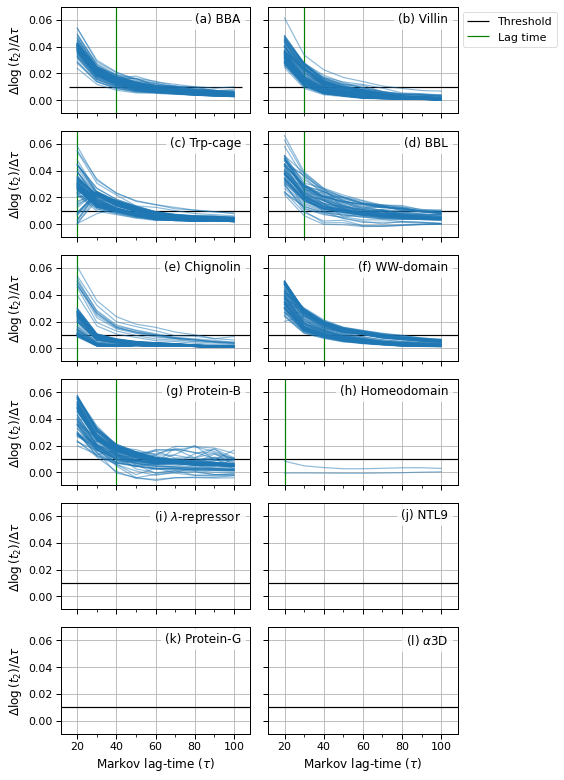

In [10]:
with sns.plotting_context('paper', font_scale=1.25):
    n_rows, n_cols = 6, 2
    sharey=True
    use_log = True # percentage change in timescale as gradient
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

    if use_log: 
        ylabel_top = r'$\Delta \log{{(t_{{{0}}})}}$'
    else:
        ylabel_top = r'$\Delta t_{{{0}}}$'
    if denom=='one':
        ylabel_bot = ''
    elif denom=='lag':
        ylabel_bot = r'/$\tau$'
    elif denom=='delta_x':
        ylabel_bot = r'/$\Delta \tau$'
        
    ylabel = ylabel_top+ylabel_bot
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]

            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            tmp = df_t.loc[df_t.protein==label, :]
            
            if sharey:
                if j == 0:
                    ax.set_ylabel(ylabel.format(timescale_num))
            else:
                ax.set_ylabel(ylabel.format(timescale_num))

            if i == n_rows - 1:
                ax.set_xlabel(r'Markov lag-time ($\tau$)')
                
            ax = sns.lineplot(data=tmp, units='hp_index', x='lag', y='grad_t', estimator=None, alpha=0.5, ax=ax)
            

            
            ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.95), 
                        xycoords='axes fraction', ha='right', va='top', 
                       bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]   
            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            
            xlim = ax.get_xlim()
            ax.hlines(grad_t_cutoff, *xlim, color='k', label='Threshold')
            ax.set_xlim()
            
            if sharey:
                ylim = axes[0, 0].get_ylim()
            else:
                ylim = ax.get_ylim()
            
            chosen_lag = chosen_lags.loc[chosen_lags.protein==label, 'lag']
            
            ax.vlines(chosen_lag, *ylim, color='g', label='Lag time')
            ax.set_ylim(ylim)
            if (i == 0) & (j == n_cols - 1):
                ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
            
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
            ax.grid()
    
    plt.tight_layout()
    plt.savefig(funcs.FIG_DIR.joinpath(f't_{timescale_num}_gradient_sharey_{sharey}_log_{use_log}_denom_{denom}.pdf'), bbox_inches='tight')

In [11]:
def get_vamps(hdf_path: Path) -> pd.DataFrame:
    ts = pd.read_hdf(hdf_path, key='vamps')
    ts_summary = ts.groupby(['lag', 'k', 'method', ], as_index=False).agg(
                            median = ("value", lambda x: np.quantile(x, 0.5)), 
                            lower = ("value", lambda x: np.quantile(x, 0.025)), 
                            upper = ("value", lambda x: np.quantile(x, 0.975)))
    ts_summary['del_lower'] = ts_summary['median'] - ts_summary['lower']
    ts_summary['del_upper'] = ts_summary['upper'] - ts_summary['median']
    return ts_summary

In [12]:
all_vamps = []
for i, path in enumerate(results_paths):
    ts = get_vamps(path)
    hp = pd.read_hdf(path, key='hp')
    hp['index'] = i #path.parents[0].stem
    df = ts.join(hp).ffill()
    all_vamps.append(df)
vamp = pd.concat(all_vamps, axis=0)

In [18]:
vamp

(18900, 21)

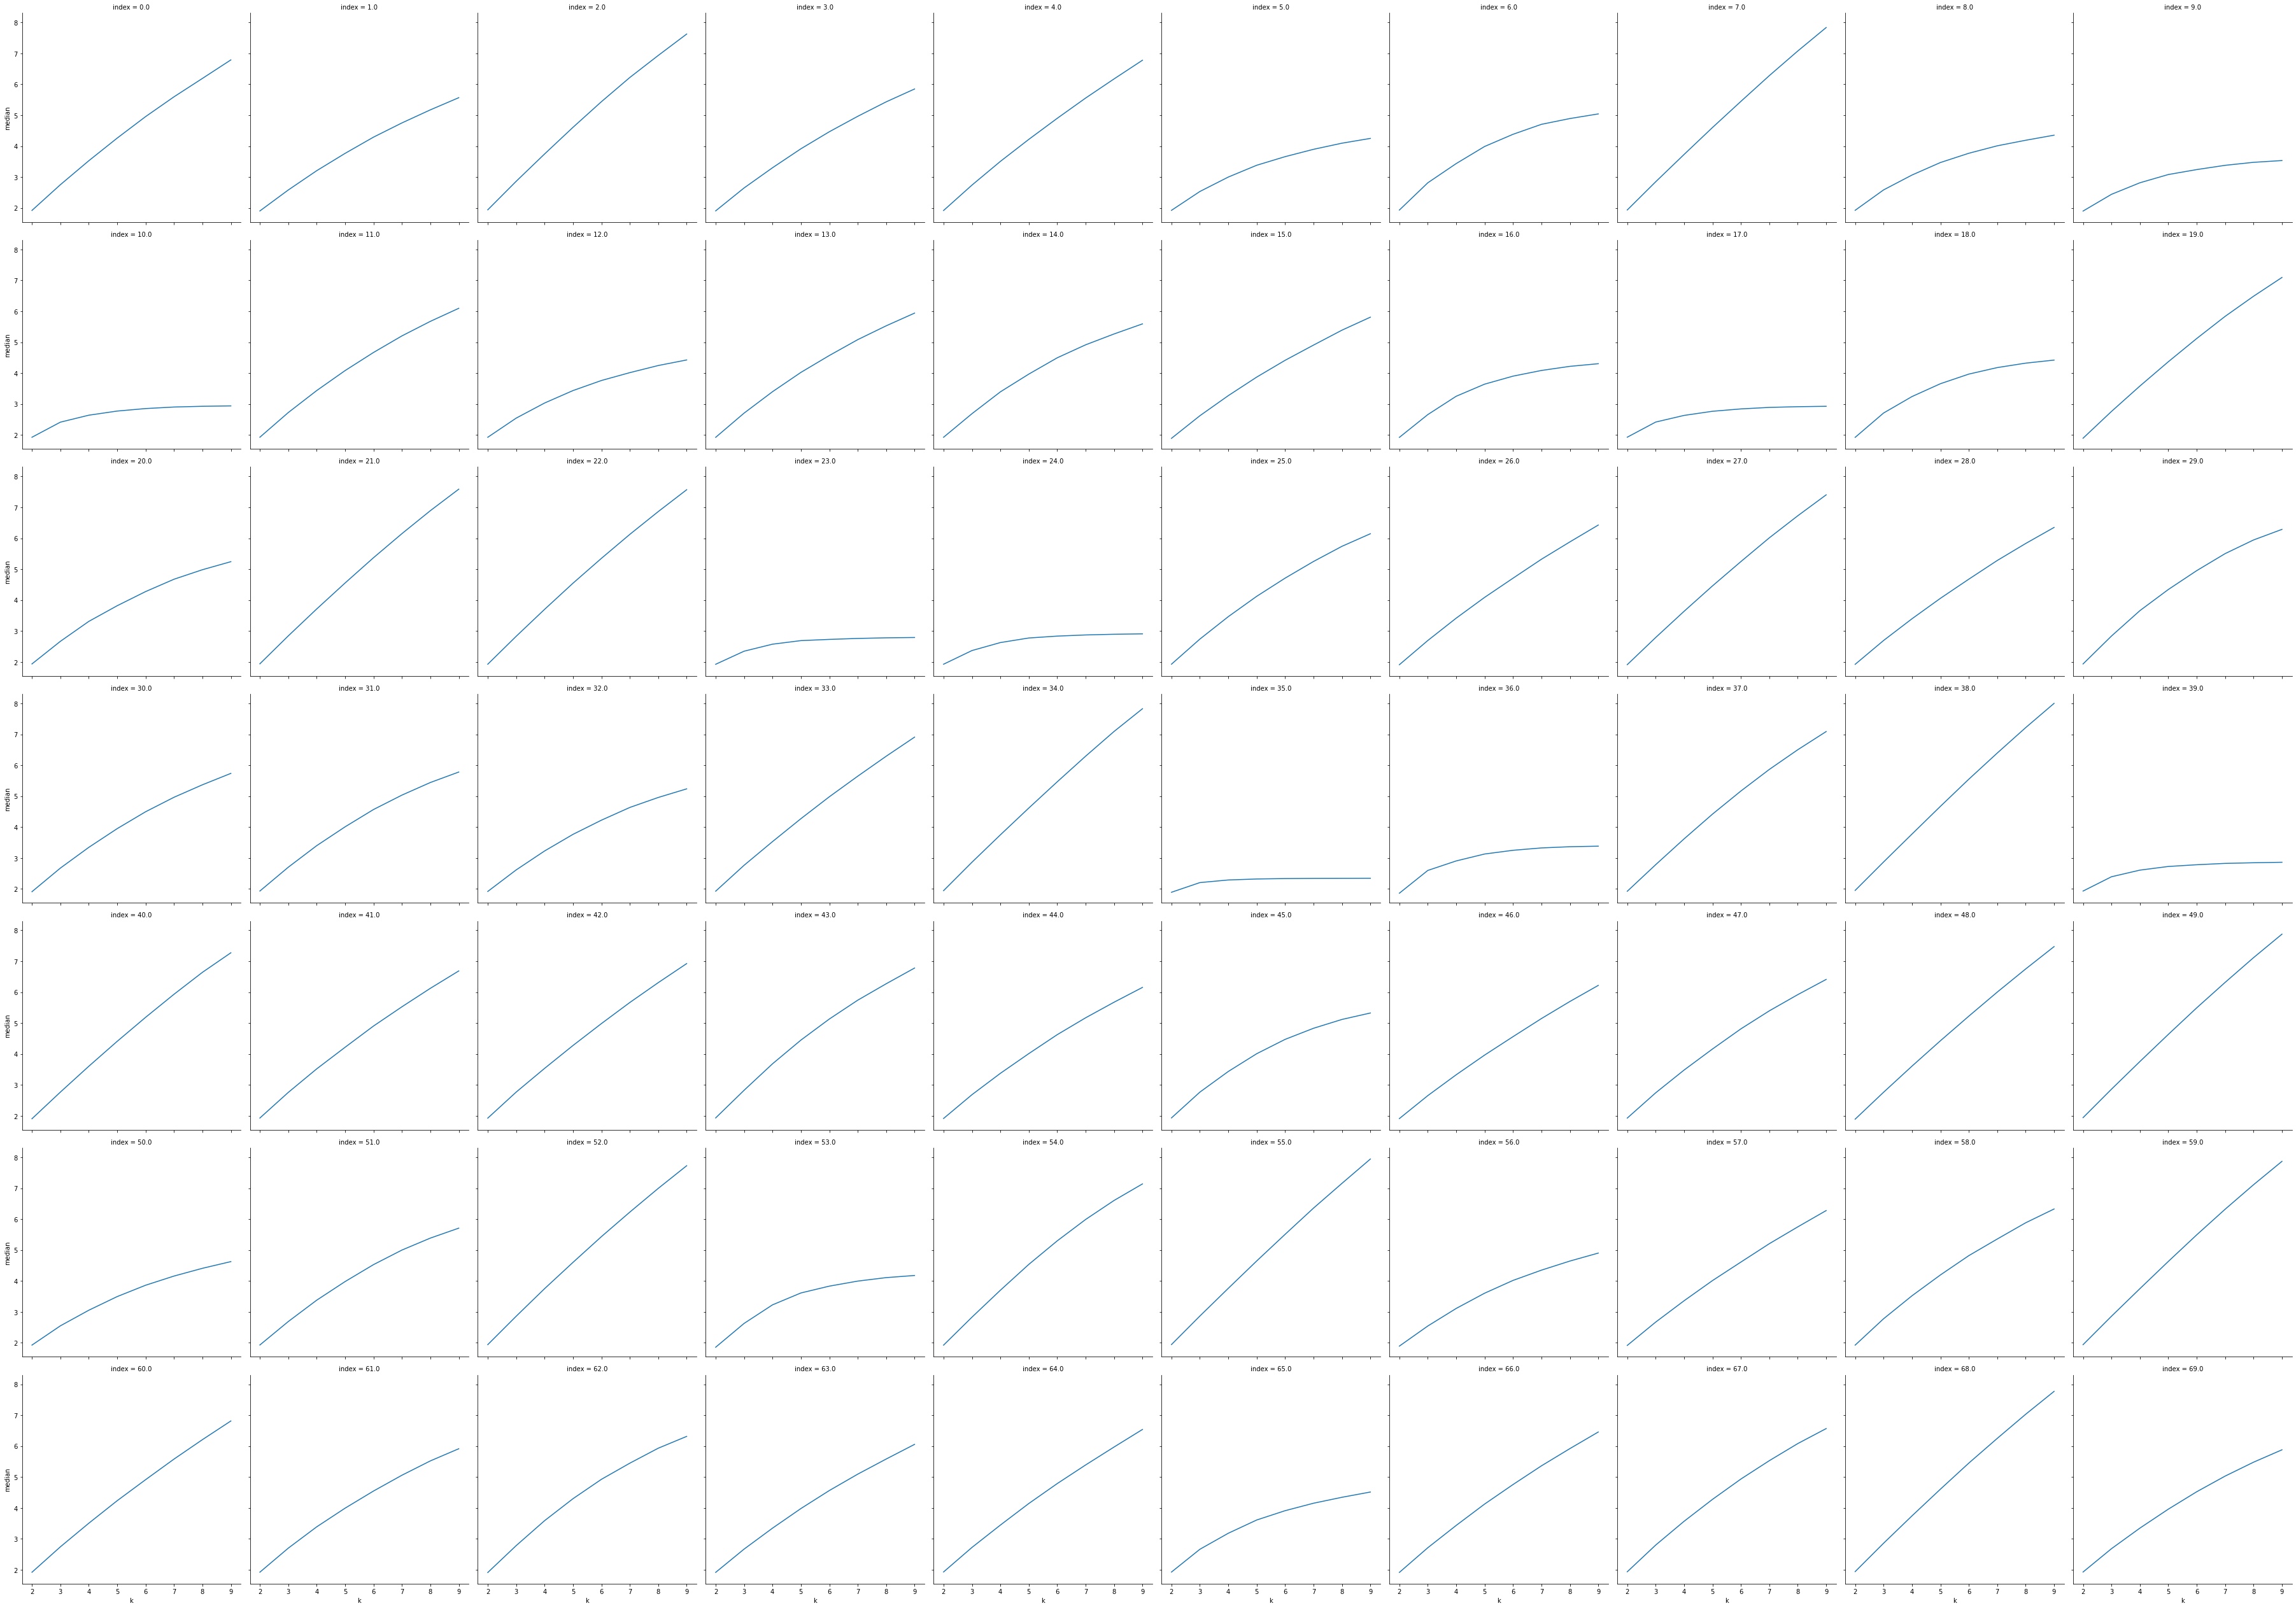

In [24]:
sns.relplot(data=vamp.loc[(vamp.lag == 100) & (vamp.k < 10) & (vamp.method=='VAMPE'), :], x='k', y='median', col='index', kind='line', col_wrap=10)

In [21]:
vamp.head()

,lag,k,method,median,lower,upper,del_lower,del_upper,cluster__k,cluster__max_iter,...,dihedrals__which,distances__centre,distances__scheme,distances__steepness,distances__transform,feature__value,tica__dim,tica__lag,tica__stride,index
0,10.0,2.0,VAMP1,1.985465,1.982302,1.990410,0.003162,0.004945,191.0,1000.0,...,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0
1,10.0,2.0,VAMP2,1.971140,1.964918,1.980912,0.006223,0.009771,191.0,1000.0,...,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0
2,10.0,2.0,VAMPE,1.971140,1.964918,1.980912,0.006223,0.009771,191.0,1000.0,...,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0
3,10.0,3.0,VAMP1,2.960169,2.941406,2.975873,0.018762,0.015704,191.0,1000.0,...,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0
4,10.0,3.0,VAMP2,2.921189,2.884928,2.952049,0.036261,0.030860,191.0,1000.0,...,all,1.402167,ca,23.955992,logistic,dihedrals,8.0,76.0,10.0,0.0
